- 用 $q(z)$ 去近似 $p(z|x)$：$q(z)\approx p(z|x)$
    - vi：就是找到 best approximation
    - $x$: observed, $z$: latent
    - $p(z|x)=\frac{p(x|z)p(z)}{p(x)}$
        - $p(x)=\int\cdots\int p(x,z_1,\cdots,z_d)dz_1\cdots dz_d$
        - intractable
    - $q(z)$ 的选择
        - $\mathcal N(\mu,\sigma^2)$, $Exp(\lambda)$, $\Gamma(\alpha,\beta)$
- $q(z)\approx p(z|x)$
    - 用kldiv度量距离，$D_{kl}(q\|p)=\mathbb E_q\left[\log\frac{q(z)}{p(z|x)}\right]$
        - 但是仍然需要知道 $p(z|x)$
    - here is elbo
$$
\log p(x)=D_{kl}(q\|p)+\underbrace{E_q\log p(x,z)-E_q\log q(z)}_{\mathcal L(q)=ELBO}
$$
- evidence = KL + ELBO
    - $\log p(x)$ is fixed,  max ELBO => min KL
        - ELBO = evidence - KL
    - 这里的 kl 是 reverse KL 的形式，mode seeking
        - 具体是哪个 mode，跟初始值有关；
    - 优化过程中检测 ELBO 以及 KL 的变化
- $q(z)$ => $q(z|x)$
    - 进一步可以推导出 $ \mathcal{L}(q) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) \,\|\, p(z)) $
- ELBO 可计算

### coding

- `loss = (log_prob_q - log_prob_p_z).mean()` 正是 KL 散度 D_KL(q || p) 的蒙特卡洛估计。

In [1]:
import torch
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

/data/hf/.cache/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-jsskqktk because there was an issue with the default path (/data/hf/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [19]:
# --- 1. 定义目标分布 p(z|x) ---
# 视频中 p(z|x) 是一个复杂的双峰分布。
# 我们用两个高斯分布的混合来模拟它 (Gaussian Mixture Model)。
# 这使得它既复杂（多峰），又是可计算的。
# p(z|x) = 0.4 * N(z | μ=-1.5, σ=0.5) + 0.6 * N(z | μ=2.0, σ=0.6)

# 定义 p(z|x) 的对数概率函数
# 我们不需要把它定义成一个类，因为它没有需要学习的参数
def log_prob_p(z):
    """计算 z 在目标分布 p(z|x) 下的对数概率"""
    # 定义两个高斯分量
    dist1 = dist.Normal(loc=-1.5, scale=0.5)
    dist2 = dist.Normal(loc=2.0, scale=0.6)
    
    # 计算混合概率密度 p(z) = w1*p1(z) + w2*p2(z)
    prob = 0.2 * torch.exp(dist1.log_prob(z)) + 0.6 * torch.exp(dist2.log_prob(z))
    
    # 返回对数概率，加上一个很小的数防止 log(0)
    return torch.log(prob + 1e-8)


# --- 2. 定义近似分布 q(z) ---
# 视频中 q(z) 是一个简单的单峰高斯分布 N(z | μ_q, σ_q)
# 它的均值 μ_q 和标准差 σ_q 是我们要优化的参数。

class QDistribution(nn.Module):
    def __init__(self, init=3.0):
        super().__init__()
        # 将均值 μ_q 初始化为一个可学习的参数
        # 初始值设为 -3.0，远离目标，以便观察优化过程
        self.mu_q = nn.Parameter(torch.tensor([init], dtype=torch.float32))
        
        # 将标准差 σ_q 的对数 log(σ_q) 初始化为可学习参数
        # 这样做可以保证 σ_q = exp(log_σ_q) 始终为正数，符合标准差的定义
        # 初始 log_σ_q=0.0，即 σ_q=1.0
        self.log_sigma_q = nn.Parameter(torch.tensor([0.0], dtype=torch.float32))

    def forward(self):
        """返回当前参数下的高斯分布对象"""
        sigma_q = torch.exp(self.log_sigma_q)
        return dist.Normal(loc=self.mu_q, scale=sigma_q)

In [20]:
# --- 3. 设置优化过程 ---

# 实例化我们的可学习分布 q
# q_distribution_model = QDistribution(init=3)
q_distribution_model = QDistribution(init=-3)

# 定义优化器，我们使用 Adam 优化器来更新 q 的参数 (mu_q, log_sigma_q)
optimizer = torch.optim.Adam(q_distribution_model.parameters(), lr=0.001)

# 定义训练超参数
num_steps = 2000  # 优化步数
batch_size = 512  # 每次蒙特卡洛采样的样本数

print("开始优化 q(z)...")
for step in range(num_steps):
    # 将梯度清零
    optimizer.zero_grad()
    
    # 从当前的 q(z) 分布中采样
    q_dist = q_distribution_model()
    # 使用 .rsample() 而不是 .sample()
    # 这是重参数化技巧（reparameterization trick），它使得梯度可以从 loss 流回分布的参数 mu 和 sigma
    z_samples = q_dist.rsample((batch_size,))
    
    # 计算采样点在 q(z) 下的对数概率
    log_prob_q = q_dist.log_prob(z_samples)
    
    # 计算采样点在 p(z|x) 下的对数概率
    log_prob_p_z = log_prob_p(z_samples)
    
    # --- 4. 计算损失函数 (KL 散度) ---
    # loss = D_KL(q || p) = E_q[log q(z) - log p(z|x)]
    # 我们用蒙特卡洛方法来估计这个期望值
    loss = (log_prob_q - log_prob_p_z).mean()
    
    # 反向传播，计算梯度
    loss.backward()
    
    # 更新 q 的参数
    optimizer.step()
    
    if (step + 1) % 50 == 0:
        # 视频中的 ELBO = E_q[log p(x,z) - log q(z)]
        # 在我们的场景中，log p(x) 是常数，所以最小化 KL 等价于最大化 ELBO
        # L(q) = E_q[log p(z|x)] - E_q[log q(z)] = -D_KL(q||p)
        elbo = -loss.item()
        print(f"Step [{step+1}/{num_steps}], "
              f"KL Loss: {loss.item():.4f}, "
              f"ELBO: {elbo:.4f}, "
              f"μ_q: {q_distribution_model.mu_q.item():.4f}, "
              f"σ_q: {torch.exp(q_distribution_model.log_sigma_q).item():.4f}")

print("优化完成!")

开始优化 q(z)...
Step [50/2000], KL Loss: 6.1519, ELBO: -6.1519, μ_q: -2.9500, σ_q: 0.9521
Step [100/2000], KL Loss: 5.5810, ELBO: -5.5810, μ_q: -2.8999, σ_q: 0.9038
Step [150/2000], KL Loss: 5.6673, ELBO: -5.6673, μ_q: -2.8497, σ_q: 0.8571
Step [200/2000], KL Loss: 5.4372, ELBO: -5.4372, μ_q: -2.7999, σ_q: 0.8149
Step [250/2000], KL Loss: 5.1359, ELBO: -5.1359, μ_q: -2.7507, σ_q: 0.7762
Step [300/2000], KL Loss: 4.4923, ELBO: -4.4923, μ_q: -2.7021, σ_q: 0.7401
Step [350/2000], KL Loss: 4.3735, ELBO: -4.3735, μ_q: -2.6542, σ_q: 0.7069
Step [400/2000], KL Loss: 4.0613, ELBO: -4.0613, μ_q: -2.6074, σ_q: 0.6788
Step [450/2000], KL Loss: 3.9408, ELBO: -3.9408, μ_q: -2.5617, σ_q: 0.6535
Step [500/2000], KL Loss: 3.5661, ELBO: -3.5661, μ_q: -2.5170, σ_q: 0.6311
Step [550/2000], KL Loss: 3.4851, ELBO: -3.4851, μ_q: -2.4736, σ_q: 0.6123
Step [600/2000], KL Loss: 3.3092, ELBO: -3.3092, μ_q: -2.4312, σ_q: 0.5964
Step [650/2000], KL Loss: 3.0565, ELBO: -3.0565, μ_q: -2.3900, σ_q: 0.5822
Step [700/200

In [21]:
final_q_dist

Normal(loc: Parameter containing:
tensor([2.0188], requires_grad=True), scale: tensor([0.6084], grad_fn=<ExpBackward0>))

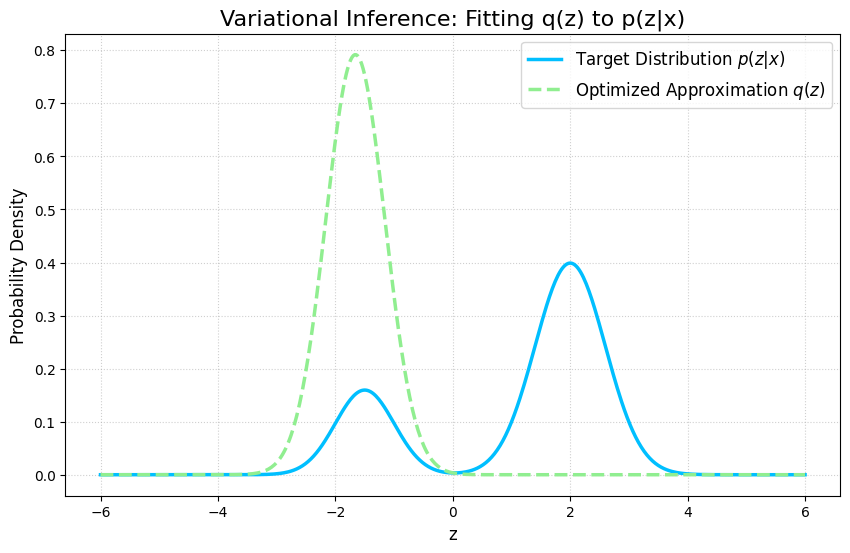


最终优化结果:
  - 均值 (μ_q): -1.6592
  - 标准差 (σ_q): 0.5038


In [22]:
# --- 5. 可视化结果 ---

# 生成用于绘图的 z 轴坐标
z_plot = torch.linspace(-6, 6, 500).unsqueeze(1)

# 计算目标分布 p(z|x) 的概率密度
p_density = torch.exp(log_prob_p(z_plot))

# 获取优化后的 q(z) 分布
final_q_dist = q_distribution_model()
# 计算优化后 q(z) 的概率密度
q_density_final = torch.exp(final_q_dist.log_prob(z_plot))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(z_plot.numpy(), p_density.numpy(), label='Target Distribution $p(z|x)$', color='deepskyblue', linewidth=2.5)
# detach() 是为了在绘图时不追踪梯度
plt.plot(z_plot.numpy(), q_density_final.detach().numpy(), label='Optimized Approximation $q(z)$', color='lightgreen', linewidth=2.5, linestyle='--')

plt.title("Variational Inference: Fitting q(z) to p(z|x)", fontsize=16)
plt.xlabel("z", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 打印最终的参数
final_mu = q_distribution_model.mu_q.item()
final_sigma = torch.exp(q_distribution_model.log_sigma_q).item()
print(f"\n最终优化结果:")
print(f"  - 均值 (μ_q): {final_mu:.4f}")
print(f"  - 标准差 (σ_q): {final_sigma:.4f}")